In [2]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

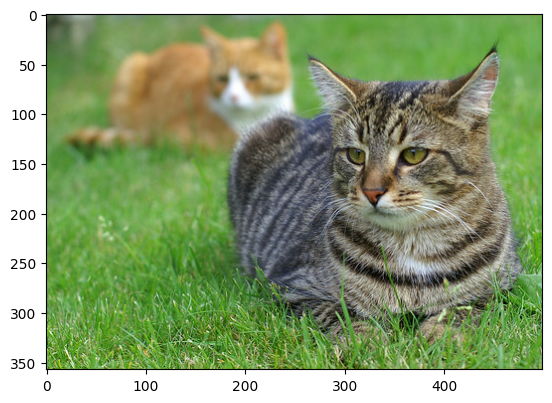

In [4]:
# from ImageNet
image = Image.open('./sample/tigercat.jpg')
# image = Image.open('./sample/dogsled.jpg')
imshow(image)

In [5]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [16]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)
print(tensor.dtype)

<class 'torch.Tensor'>


In [8]:
model = models.resnet18(pretrained=True)
model.eval()
print(model)

/home/weird-lab/miniconda3/envs/viz/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/weird-lab/miniconda3/envs/viz/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/weird-lab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.6MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# the target layer you want to visualize
target_layer = model.layer4[1].conv2
print(target_layer)

# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(model, target_layer)
# wrapped_model =GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [11]:
cam, idx = wrapped_model(tensor)

/home/weird-lab/miniconda3/envs/viz/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 282	 probability 0.45813292264938354


In [12]:
print(idx2label[idx])

tiger cat


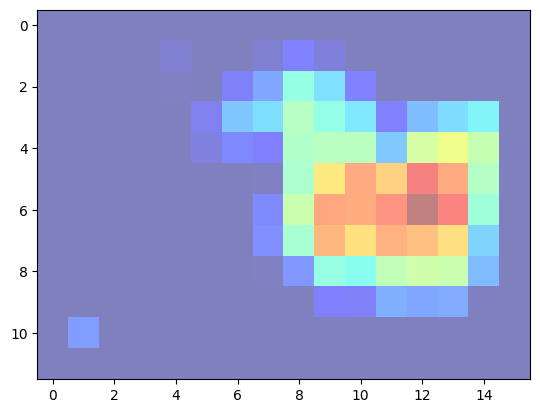

In [13]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [11]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [12]:
heatmap = visualize(img, cam)

In [13]:
# save image
# save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

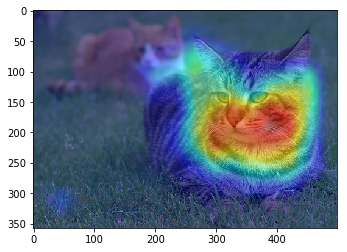

In [14]:
# or visualize on Jupyter
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0)).astype(np.int32)
imshow(hm)